In [1]:
import skimage as sk
from skimage.io import imread, imshow, imsave
import numpy as np
import os
from glob import glob
import napari
import pyclesperanto as cle
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
help(cle.scale)

In [ ]:
def segment_on_GPU(input_image,spot_sigma,outline_sigma,voxel_size_z,voxel_size_y,voxel_size_x):
    input_gpu = cle.push(input_image)
    resampled = cle.create([int(input_gpu.shape[0] * voxel_size_z), int(input_gpu.shape[1] * voxel_size_y), int(input_gpu.shape[2] * voxel_size_x)])
    cle.scale(input_gpu, resampled, factor_x=voxel_size_x, factor_y=voxel_size_y, factor_z=voxel_size_z, centered=False)
    #normalize the image stack
    equalized_intensities_stack = cle.create_like(resampled)
    a_slice = cle.create([resampled.shape[1], resampled.shape[2]])
    num_slices = resampled.shape[0]
    mean_intensity_stack = cle.mean_of_all_pixels(resampled)
    corrected_slice = None
    for z in range(0, num_slices):
        # get a single slice out of the stack
        cle.copy_slice(resampled, a_slice, z)
        # measure its intensity
        mean_intensity_slice = cle.mean_of_all_pixels(a_slice)
        # correct the intensity
        correction_factor = mean_intensity_slice/mean_intensity_stack
        corrected_slice = cle.multiply_image_and_scalar(a_slice, corrected_slice, correction_factor)
        # copy slice back in a stack
        cle.copy_slice(corrected_slice, equalized_intensities_stack, z)
    #background subtraction
    background_subtracted = cle.top_hat_box(equalized_intensities_stack, radius_x=10, radius_y=10, radius_z=10)
    #get seed points
    blurred = cle.gaussian_blur(background_subtracted, sigma_x=spot_sigma, sigma_y=spot_sigma, sigma_z=spot_sigma)
    detected_spots = cle.detect_maxima_box(blurred, radius_x=1, radius_y=1, radius_z=1)
    #segment signal
    blurred = cle.gaussian_blur(background_subtracted, sigma_x=outline_sigma, sigma_y=outline_sigma, sigma_z=outline_sigma)
    copy_blurred = cle.copy(blurred)
    blurred_cpu = cle.pull(copy_blurred)
    thresh = sk.filters.threshold_multiotsu(blurred_cpu, classes=5)
    mask = blurred > thresh[1]
    selected_spots = cle.binary_and(mask, detected_spots)
    voronoi_diagram = cle.masked_voronoi_labeling(selected_spots, mask)
    df = pd.DataFrame(cle.statistics_of_labelled_pixels(resampled, voronoi_diagram))
    #pull data off gpu
    input_pull = cle.pull(input_gpu)
    background_subtracted_pull = cle.pull(background_subtracted)
    equalized_intensities_stack_pull = cle.pull(equalized_intensities_stack)
    mean_intensity_stack_pull = cle.pull(mean_intensity_stack)
    blurred_pull = cle.pull(blurred)
    voronoi_diagram_pull = cle.pull(voronoi_diagram)
    resampled_pull = cle.pull(resampled)
    detected_spots_pull = cle.pull(detected_spots)
    selected_spots_pull = cle.pull(selected_spots)
    mask_pull = cle.pull(mask)
    return voronoi_diagram_pull, resampled_pull, detected_spots_pull, selected_spots_pull, df

In [47]:
def segment_on_GPU_no_resample(input_image,spot_sigma,outline_sigma,voxel_size_z,voxel_size_y,voxel_size_x):
    input_gpu = cle.push(input_image)
    #resampled = cle.create([int(input_gpu.shape[0] * voxel_size_z), int(input_gpu.shape[1] * voxel_size_y), int(input_gpu.shape[2] * voxel_size_x)])
    #cle.scale(input_gpu, resampled, factor_x=voxel_size_x, factor_y=voxel_size_y, factor_z=voxel_size_z, centered=False)
    #normalize the image stack
    equalized_intensities_stack = cle.create_like(input_gpu)
    a_slice = cle.create([input_gpu.shape[1], input_gpu.shape[2]])
    num_slices = input_gpu.shape[0]
    mean_intensity_stack = cle.mean_of_all_pixels(input_gpu)
    corrected_slice = None
    for z in range(0, num_slices):
        # get a single slice out of the stack
        cle.copy_slice(input_gpu, a_slice, z)
        # measure its intensity
        mean_intensity_slice = cle.mean_of_all_pixels(a_slice)
        # correct the intensity
        correction_factor = mean_intensity_slice/mean_intensity_stack
        corrected_slice = cle.multiply_image_and_scalar(a_slice, corrected_slice, correction_factor)
        # copy slice back in a stack
        cle.copy_slice(corrected_slice, equalized_intensities_stack, z)
    #background subtraction
    background_subtracted = cle.subtract_gaussian_background(equalized_intensities_stack, sigma_x=int(input_gpu.shape[2]/3), sigma_y=int(input_gpu.shape[1]/3), sigma_z=int(input_gpu.shape[0]/3))
    background_subtracted_top_hat = cle.top_hat_sphere(background_subtracted,radius_x=10,radius_y=10,radius_z=10)
    #get seed points
    blurred = cle.gaussian_blur(background_subtracted_top_hat, sigma_x=spot_sigma, sigma_y=spot_sigma, sigma_z=spot_sigma)
    detected_spots = cle.detect_maxima_box(blurred, radius_x=1, radius_y=1, radius_z=1)
    #segment signal
    blurred = cle.gaussian_blur(background_subtracted_top_hat, sigma_x=outline_sigma, sigma_y=outline_sigma, sigma_z=outline_sigma)
    copy_blurred = cle.copy(blurred)
    blurred_cpu = cle.pull(copy_blurred)
    #add in extra filter here
    thresh = sk.filters.threshold_multiotsu(blurred_cpu, classes=5)
    mask = blurred > thresh[1]
    selected_spots = cle.binary_and(mask, detected_spots)
    voronoi_diagram = cle.masked_voronoi_labeling(selected_spots, mask)
    df = pd.DataFrame(cle.statistics_of_labelled_pixels(input_gpu, voronoi_diagram))
    #pull data off gpu
    input_pull = cle.pull(input_gpu)
    background_subtracted_pull = cle.pull(background_subtracted)
    background_subtracted_top_hat_pull = cle.pull(background_subtracted_top_hat)
    equalized_intensities_stack_pull = cle.pull(equalized_intensities_stack)
    mean_intensity_stack_pull = cle.pull(mean_intensity_stack)
    blurred_pull = cle.pull(blurred)
    voronoi_diagram_pull = cle.pull(voronoi_diagram)
    #resampled_pull = cle.pull(resampled)
    detected_spots_pull = cle.pull(detected_spots)
    selected_spots_pull = cle.pull(selected_spots)
    mask_pull = cle.pull(mask)
    return voronoi_diagram_pull, detected_spots_pull, selected_spots_pull, df, background_subtracted_top_hat_pull,blurred_pull

In [ ]:
def get_3D_meshes(mask_img):
    array = []
    for i in range(1,int(np.max(mask_img)+1)):
        obj = mask_img == int(i)
        verts, faces, _ , _ = sk.measure.marching_cubes(obj, level=0.0)
        surf_area = sk.measure.mesh_surface_area(verts, faces)
        array.append(surf_area)
    measurements = pd.Series(array,name='Surface_Area')
    return measurements

In [3]:
cle.select_device("NVIDIA")

(OpenCL) NVIDIA RTX A4000 (OpenCL 3.0 CUDA)
	Vendor:                      NVIDIA Corporation
	Driver Version:              572.83
	Device Type:                 GPU
	Compute Units:               48
	Global Memory Size:          16375 MB
	Local Memory Size:           0 MB
	Maximum Buffer Size:         4093 MB
	Max Clock Frequency:         1560 MHz
	Image Support:               Yes

### Reading in images

In [4]:
#set voxel size for images
voxel_size_x = 0.301
voxel_size_y = 0.301
voxel_size_z = 4.55

In [5]:
CMO_files = sorted(glob('E:/ParadaKusz_Lab/TIF_Files/Control_MO/*.tif'))
GMO_1ng_files = sorted(glob('E:/ParadaKusz_Lab/TIF_Files/GNAS_MO_1ng/*.tif'))
GMO_2ng_files = sorted(glob('E:/ParadaKusz_Lab/TIF_Files/GNAS_MO_2ng/*.tif'))

In [6]:
CMO_imgs = list(map(sk.io.imread,CMO_files))
GMO_1ng_imgs = list(map(sk.io.imread,GMO_1ng_files))
GMO_2ng_imgs = list(map(sk.io.imread,GMO_2ng_files))

In [ ]:
input_image = GMO_2ng_imgs[1]
spot_sigma = 9
outline_sigma = 1
voronoi_diagram_pull, detected_spots_pull, selected_spots_pull, df, background_subtracted_top_hat_pull,blurred_pull = segment_on_GPU_no_resample(
    input_image,spot_sigma,outline_sigma,voxel_size_z,voxel_size_y,voxel_size_x)

In [45]:
viewer = napari.view_image(background_subtracted_top_hat_pull,name='img',scale=[voxel_size_z,voxel_size_y,voxel_size_x])
viewer.add_image(voronoi_diagram_pull, name='masks',scale=[voxel_size_z,voxel_size_y,voxel_size_x])

<Image layer 'masks' at 0x29942b3cbb0>

In [28]:
props = sk.measure.regionprops_table(voronoi_diagram_pull,background_subtracted_pull,properties=('label','area','intensity_mean'))
props_df = pd.DataFrame(props)
props_df.tail()
filtered_props = props_df.loc[props_df['intensity_mean']>25]
filtered_props.head()
   

,label,area,intensity_mean
110,111,28241.0,25.650614
123,124,33068.0,30.665167
127,128,30445.0,31.733582
143,144,29894.0,32.591034
147,148,23620.0,29.883675


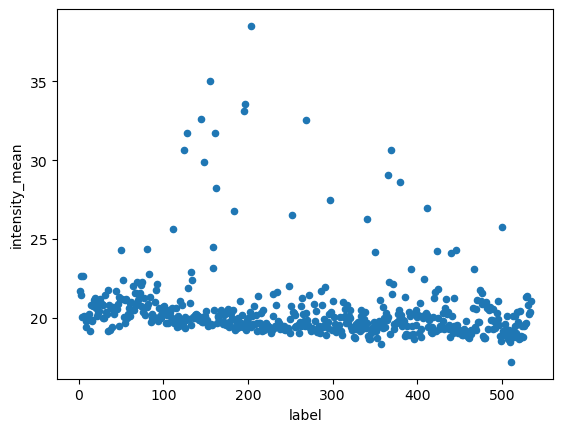

In [27]:
fig,ax = plt.subplots()
props_df.plot(x='label',y='intensity_mean',kind='scatter',ax=ax)
plt.show()

In [29]:
filtered_mask = np.isin(voronoi_diagram_pull, np.asarray(filtered_props['label'])).astype(int)

In [30]:
filtered_labels = filtered_mask*voronoi_diagram_pull

In [32]:
viewer = napari.view_image(background_subtracted_pull,name='img',scale=[voxel_size_z,voxel_size_y,voxel_size_x])
viewer.add_image(voronoi_diagram_pull, name='masks',scale=[voxel_size_z,voxel_size_y,voxel_size_x])
viewer.add_image(filtered_labels,name='filtered',scale=[voxel_size_z,voxel_size_y,voxel_size_x])

<Image layer 'filtered' at 0x29938506040>

In [20]:
viewer = napari.view_image(voronoi_diagram_pull, name='masks',scale=[voxel_size_z,voxel_size_y,voxel_size_x])
viewer.add_image(input_image,name='img',scale=[voxel_size_z,voxel_size_y,voxel_size_x])
viewer.add_image(background_subtracted_pull,name='equal',scale=[voxel_size_z,voxel_size_y,voxel_size_x])

<Image layer 'equal' at 0x298624ca610>

## Plan: preprocess, threshold signal, connected components, post-process objects, measure volume and SA to get ratio, measure fluorescence values, PCA on volume/SA to find threshold for splitting into active and inactive state?

#### Trying to get GPU use working

In [ ]:
test_img = CMO_imgs[6]

In [ ]:
input_gpu = cle.push(test_img)
input_gpu

Inspect 3D data

In [ ]:
def show(image_to_show, labels=False):
    """
    This function generates three projections: in X-, Y- and Z-direction and shows them.
    """
    projection_x = cle.maximum_x_projection(image_to_show)
    projection_y = cle.maximum_y_projection(image_to_show)
    projection_z = cle.maximum_z_projection(image_to_show)

    fig, axs = plt.subplots(1, 3, figsize=(15, 15))
    axs[0].imshow(projection_x, cmap='prism' if labels else 'gray')
    axs[1].imshow(projection_y, cmap='prism' if labels else 'gray')
    axs[2].imshow(projection_z, cmap='prism' if labels else 'gray')
    plt.show()

show(input_gpu)
print(input_gpu.shape)

In [ ]:
#Resample to make isotropic
resampled = cle.create([int(input_gpu.shape[0] * voxel_size_z), int(input_gpu.shape[1] * voxel_size_y), int(input_gpu.shape[2] * voxel_size_x)])
cle.scale(input_gpu, resampled, factor_x=voxel_size_x, factor_y=voxel_size_y, factor_z=voxel_size_z, centered=False)

show(resampled)
print(resampled.shape)

May not have enough Z resolution for resonable reasults

In [ ]:
equalized_intensities_stack = cle.create_like(resampled)
a_slice = cle.create([resampled.shape[1], resampled.shape[2]])

num_slices = resampled.shape[0]
mean_intensity_stack = cle.mean_of_all_pixels(resampled)

corrected_slice = None
for z in range(0, num_slices):
    # get a single slice out of the stack
    cle.copy_slice(resampled, a_slice, z)
    # measure its intensity
    mean_intensity_slice = cle.mean_of_all_pixels(a_slice)
    # correct the intensity
    correction_factor = mean_intensity_slice/mean_intensity_stack
    corrected_slice = cle.multiply_image_and_scalar(a_slice, corrected_slice, correction_factor)
    # copy slice back in a stack
    cle.copy_slice(corrected_slice, equalized_intensities_stack, z)

#show(equalized_intensities_stack)

In [ ]:
#Correct background
background_subtracted = cle.top_hat_box(equalized_intensities_stack, radius_x=10, radius_y=10, radius_z=10)
#show(background_subtracted)

In [ ]:
segmented = cle.voronoi_otsu_labeling(background_subtracted, spot_sigma=5, outline_sigma=2)
show(segmented, labels=True)

In [ ]:
help(cle.detect_maxima_box)

In [ ]:
sigma_spot_detection = 7
blurred = cle.gaussian_blur(background_subtracted, sigma_x=sigma_spot_detection, sigma_y=sigma_spot_detection, sigma_z=sigma_spot_detection)
#enough of a blue to remove most of the texture of the objects wihle retaining their presence

detected_spots = cle.detect_maxima_box(blurred, radius_x=1, radius_y=1, radius_z=1)

number_of_spots = cle.sum_of_all_pixels(detected_spots)
print("number of detected spots", number_of_spots)
#viewer = napari.view_image(blurred, name='blurred')
#viewer.add_image(detected_spots, name='spots')
# fig, axs = plt.subplots(1, 2, figsize=(15, 15))
# axs[0].imshow(blurred[95,300:500,300:])
# axs[1].imshow(detected_spots[95,300:500,300:])
# plt.show()

In [ ]:
sigma_outline = 1
blurred = cle.gaussian_blur(background_subtracted, sigma_x=sigma_outline, sigma_y=sigma_outline, sigma_z=sigma_outline)
#Smaller blur to make threhsolding easier and maintain reasonable boundaries

# binary = cle.threshold_otsu(blurred)
# viewer = napari.view_image(blurred, name='blurred')
# viewer.add_image(binary, name='mask')

In [ ]:
copy_blurred = cle.copy(blurred)
copy_background_subtracted = cle.copy(background_subtracted)

In [ ]:
help(cle.greater)

In [ ]:
blurred_cpu = cle.pull(copy_blurred)
iso_norm = cle.pull(copy_background_subtracted)

In [ ]:
#testing thresholds

thresh = sk.filters.threshold_multiotsu(blurred_cpu, classes=5)
print(thresh)
mask = blurred>thresh[1]

# viewer = napari.view_image(blurred, name='blurred')
# viewer.add_image(mask, name='mask')
# viewer.add_image(iso_norm, name='iso data')

In [ ]:
viewer = napari.view_image(iso_norm, name='iso data')
viewer.add_image(blurred, name='blurred')
viewer.add_image(mask, name='mask')

In [ ]:
mask_gpu = blurred > thresh[1]
viewer = napari.view_image(mask_gpu, name='mask')

In [ ]:
selected_spots = cle.binary_and(mask_gpu, detected_spots)

number_of_spots = cle.sum_of_all_pixels(selected_spots)
print("number of selected spots", number_of_spots)

viewer = napari.view_image(mask_gpu, name='mask')
viewer.add_image(detected_spots, name='Original Spots')
viewer.add_image(selected_spots, name='Filtered Spots')

In [ ]:
voronoi_diagram = cle.masked_voronoi_labeling(selected_spots, mask_gpu)
viewer = napari.view_image(voronoi_diagram, name='mask')
viewer.add_image(background_subtracted, name='blurred_img')

In [ ]:
df = pd.DataFrame(
    cle.statistics_of_labelled_pixels(resampled, voronoi_diagram)
    )
df.head()
df.to_csv(os.path.join(save_df_path,'measurements_'+clean_name+'.csv'))

## Creating Functions

In [ ]:
def segment_on_GPU(input_image,spot_sigma,outline_sigma,voxel_size_z,voxel_size_y,voxel_size_x):
    input_gpu = cle.push(input_image)
    resampled = cle.create([int(input_gpu.shape[0] * voxel_size_z), int(input_gpu.shape[1] * voxel_size_y), int(input_gpu.shape[2] * voxel_size_x)])
    cle.scale(input_gpu, resampled, factor_x=voxel_size_x, factor_y=voxel_size_y, factor_z=voxel_size_z, centered=False)
    #normalize the image stack
    equalized_intensities_stack = cle.create_like(resampled)
    a_slice = cle.create([resampled.shape[1], resampled.shape[2]])
    num_slices = resampled.shape[0]
    mean_intensity_stack = cle.mean_of_all_pixels(resampled)
    corrected_slice = None
    for z in range(0, num_slices):
        # get a single slice out of the stack
        cle.copy_slice(resampled, a_slice, z)
        # measure its intensity
        mean_intensity_slice = cle.mean_of_all_pixels(a_slice)
        # correct the intensity
        correction_factor = mean_intensity_slice/mean_intensity_stack
        corrected_slice = cle.multiply_image_and_scalar(a_slice, corrected_slice, correction_factor)
        # copy slice back in a stack
        cle.copy_slice(corrected_slice, equalized_intensities_stack, z)
    #background subtraction
    background_subtracted = cle.top_hat_box(equalized_intensities_stack, radius_x=10, radius_y=10, radius_z=10)
    #get seed points
    blurred = cle.gaussian_blur(background_subtracted, sigma_x=spot_sigma, sigma_y=spot_sigma, sigma_z=spot_sigma)
    detected_spots = cle.detect_maxima_box(blurred, radius_x=1, radius_y=1, radius_z=1)
    #segment signal
    blurred = cle.gaussian_blur(background_subtracted, sigma_x=outline_sigma, sigma_y=outline_sigma, sigma_z=outline_sigma)
    copy_blurred = cle.copy(blurred)
    blurred_cpu = cle.pull(copy_blurred)
    thresh = sk.filters.threshold_multiotsu(blurred_cpu, classes=5)
    mask = blurred > thresh[1]
    selected_spots = cle.binary_and(mask, detected_spots)
    voronoi_diagram = cle.masked_voronoi_labeling(selected_spots, mask)
    df1 = pd.DataFrame(cle.statistics_of_labelled_pixels(resampled, voronoi_diagram))
    voronoi_diagram_cpu = cle.pull(voronoi_diagram)
    resampled_cpu = cle.pull(resampled)
    # meshes = sk.measure.marching_cubes(voronoi_diagram_cpu, spacing=voxels)
    # df2 = sk.measure.regionprops_table(voronoi_diagram_cpu, resampled_cpu,properties=('label','area','intensity_max','intensity_mean','intensity_min'))
    # df2 = pd.DataFrame.from_dict(df2)
    #df1.to_csv(os.path.join('E:/ParadaKusz_Lab/Test_Outputs','test_clemeasurements.csv'))
    # df2.to_csv(os.path.join('E:/ParadaKusz_Lab/Test_Outputs','test_skmeasurements.csv'))
    return voronoi_diagram_cpu, resampled_cpu, df1 
    

In [ ]:
test_img = CMO_imgs[1]
voroni_diagram, resampled_img, df = segment_on_GPU(test_img,7,1,voxels[0],voxels[1],voxels[2])

In [ ]:
df.head()

### Testing a bounding box crop approach to getting surface area measurements (too complicated)

In [ ]:
bbox_min_x = np.asarray(df.loc[:,'bbox_min_x'], dtype=int)
bbox_min_y = np.asarray(df.loc[:,'bbox_min_y'], dtype=int)
bbox_min_z = np.asarray(df.loc[:,'bbox_min_z'], dtype=int)
width = np.asarray(df.loc[:,'bbox_width'], dtype=int)
height = np.asarray(df.loc[:,'bbox_height'], dtype=int)
depth = np.asarray(df.loc[:,'bbox_depth'], dtype=int)

In [ ]:
bbox_min_x

In [ ]:
obj = cle.crop(voroni_diagram, 
               start_x=bbox_min_x[0],start_y=bbox_min_y[0],start_z=bbox_min_z[0],width=width[0],height=height[0],depth=depth[0])
viewer = napari.view_image(obj, name='test')

In [ ]:
obj_cpu = cle.pull(obj)
verts, faces, _ , _ = sk.measure.marching_cubes(obj_cpu, level=0.0,spacing=voxels)
surf_area = sk.measure.mesh_surface_area(verts, faces)

In [ ]:
help(cle.crop)

### Testing a threshold-type approach to getting surface area measurements (easier and less room for error)

In [ ]:
obj_thresh = voroni_diagram == 8
viewer = napari.view_image(obj_thresh, name='test')

In [ ]:
labels_cpu = cle.pull(voroni_diagram)
max_lab = int(np.max(labels_cpu))
max_lab

In [ ]:
def get_3D_meshes(mask_img):
    array = []
    labels_cpu = cle.pull(mask_img)
    for i in range(1,int(np.max(labels_cpu)+1)):
        obj = labels_cpu == int(i)
        verts, faces, _ , _ = sk.measure.marching_cubes(obj, level=0.0)
        surf_area = sk.measure.mesh_surface_area(verts, faces)
        array.append(surf_area)
    measurements = pd.Series(array,name='Surface_Area')
    return measurements

In [ ]:
surface_areas = get_3D_meshes(voroni_diagram)

In [ ]:
surface_areas.tail()

In [ ]:
merged_df = pd.concat([df,surface_areas], axis=1)


In [ ]:
merged_df.to_csv(os.path.join('E:/ParadaKusz_Lab/Test_Outputs','test_mergedmeasurements2.csv'))

In [ ]:
verify = sk.measure.regionprops_table(labels_cpu, labels_cpu, properties=('label','intensity_max'))
verify_df = pd.DataFrame.from_dict(verify)
verify_df.to_csv(os.path.join('E:/ParadaKusz_Lab/Test_Outputs','test_verifylabels.csv'))

In [ ]:
#testing function
voroni_diagram, resampled_img = segment_on_GPU(test_img,7,1,voxels[0],voxels[1],voxels[2])
voroni_diagram.shape

In [ ]:
np.max(voroni_diagram)

In [ ]:
#Creating meshes and measuring volume surface area
obj_cpu = cle.pull(obj_thresh)
verts, faces, _ , _ = sk.measure.marching_cubes(obj_cpu, level=0.0,spacing=voxels)
surf_area = sk.measure.mesh_surface_area(verts, faces)

In [ ]:
print(surf_area)

In [ ]:
def saving():
     #save everything
    equalized_intensities_stack_cpu = cle.pull(equalized_intensities_stack)
    imsave(os.path.join(cp_masks_path,'equalized_resampled_'+files[i]), equalized_intensities_stack_cpu)
    